# Lecture 4: Model Selection

**Can I trust you?**

Joaquin Vanschoren

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['figure.dpi'] = 120 # Use 300 for PDF, 100 for slides
HTML('''<style>html, body{overflow-y: visible !important} th{font-size: 20px} td{font-size: 20px} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
interactive = False # Set to True for interactive plots 
if interactive:
    plt.rcParams['figure.dpi'] = 150
else:
    plt.rcParams['figure.dpi'] = 100

## Evaluation
- To know whether we can _trust_ our method or system, we need to evaluate it.
- Model selection: choose between different models in a data-driven way.
    - If you cannot measure it, you cannot improve it.
- Convince others that your work is meaningful
    - Peers, leadership, clients, yourself(!)
- When possible, try to _interpret_ what your model has learned 
    - The signal your model found may just be an artifact of your biased data
    - See 'Why Should I Trust You?' by Marco Ribeiro et al.
    
<img src="../images/eval_trust.png" alt="ml" style="width: 400px;"/>

### Designing Machine Learning systems

* Just running your favourite algorithm is usually not a great way to start
* Consider the problem: How to measure success? Are there costs involved?
    - Do you want to understand phenomena or do black box modelling?
* Analyze your model's mistakes. Don't just finetune endlessly.
    - Build early prototypes. Should you collect more, or additional data?
    - Should the task be reformulated?
* Overly complex machine learning systems are hard to maintain
    - See 'Machine Learning: The High Interest Credit Card of Technical Debt'   

<img src="../images/eval_debt2.png" alt="ml" style="width: 700px;"/>

### Real world evaluations
* Evaluate predictions, but also how outcomes improve _because of them_
* Beware of feedback loops: predictions can influence future input data
    * Medical recommendations, spam filtering, trading algorithms,...
* Evaluate algorithms _in the wild_.
    * A/B testing: split users in groups, test different models in parallel
    * Bandit testing: gradually direct more users to the winning system

<img src="../images/eval_abbandit.png" alt="ml" style="width: 500px;"/>

# Performance estimation techniques
* Always evaluate models _as if they are predicting future data_
* We do not have access to future data, so we pretend that some data is hidden
* Simplest way: the _holdout_ (simple train-test split)
    - _Randomly_ split data (and corresponding labels) into training and test set (e.g. 75%-25%)
    - Train (fit) a model on the training data, score on the test data

In [2]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit, train_test_split,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
from matplotlib.patches import Patch
np.random.seed(1338)
cmap_data = plt.cm.brg
cmap_group = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
rng = np.random.RandomState(42)
group_prior = rng.dirichlet([2]*10)
rng.multinomial(100, group_prior)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

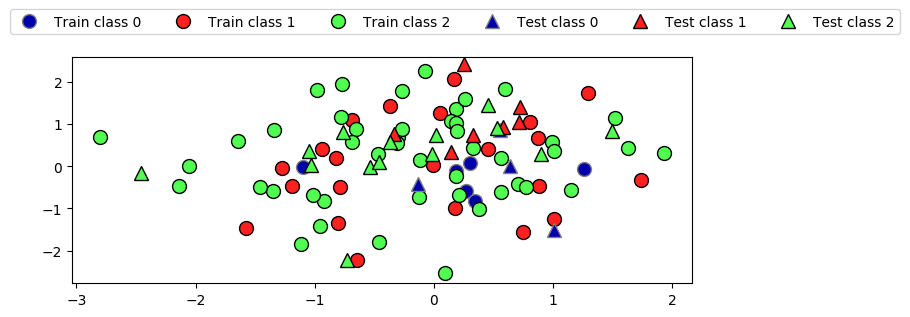

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
fig, ax = plt.subplots(figsize=(8, 3))
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                         markers='o', ax=ax)
mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                         markers='^', ax=ax)
ax.legend(["Train class 0", "Train class 1", "Train class 2", "Test class 0",
                "Test class 1", "Test class 2"], ncol=6,  loc=(-0.1, 1.1));

## K-fold Cross-validation
- Each random split can yield very different models (and scores)
    - e.g. all easy (of hard) examples could end up in the test set
- Split data into _k_ equal-sized parts, called _folds_
    - Create _k_ splits, each time using a different fold as the test set
- Compute _k_ evaluation scores, aggregate afterwards (e.g. take the mean)
- Examine the score variance to see how _sensitive_ (unstable) models are
- Large _k_ gives better estimates (more training data), but is expensive

In [4]:
def plot_cv_indices(cv, X, y, group, ax, lw=2, show_groups=False, s=700, legend=True):
    """Create a sample plot for indices of a cross-validation object."""
    n_splits = cv.get_n_splits(X, y, group)

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter([n_splits - ii - 1] * len(indices), range(len(indices)),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2, s=s)

    # Plot the data classes and groups at the end
    ax.scatter([-1] * len(X), range(len(X)), 
               c=y, marker='_', lw=lw, cmap=cmap_data, s=s)
    yticklabels = ['class'] + list(range(1, n_splits + 1))
    
    if show_groups:
        ax.scatter([-2] * len(X), range(len(X)), 
                   c=group, marker='_', lw=lw, cmap=cmap_group, s=s)
        yticklabels.insert(0, 'group')

    # Formatting
    ax.set(xticks=np.arange(-1 - show_groups, n_splits), xticklabels=yticklabels,
            ylabel='Sample index', xlabel="CV iteration",
            xlim=[-1.5 - show_groups, n_splits+.2], ylim=[-6, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    if legend:
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
                  ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks(())
    return ax

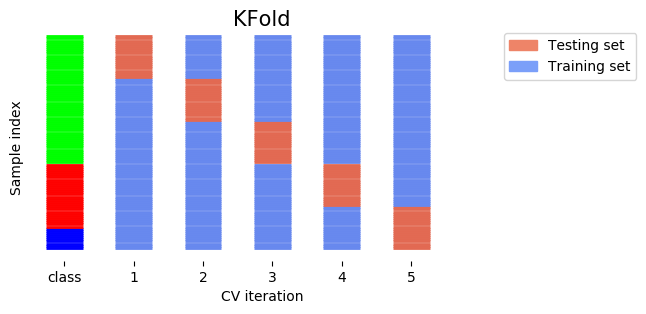

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = KFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700);

Can you explain this result?

``` python
kfold = KFold(n_splits=3)
cross_val_score(logistic_regression, iris.data, iris.target, cv=kfold)
```

In [6]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()
kfold = KFold(n_splits=3)
print("Cross-validation scores KFold(n_splits=3):\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores KFold(n_splits=3):
[0. 0. 0.]


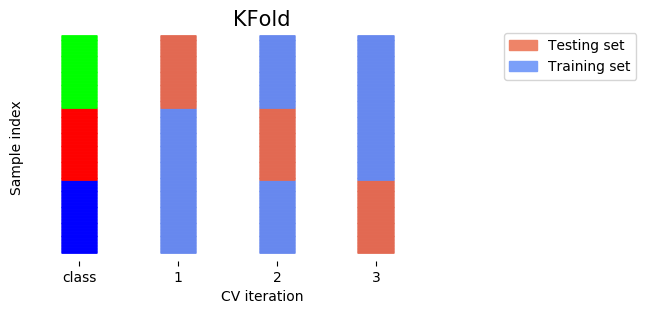

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(kfold, iris.data, iris.target, iris.target, ax, s=700)
ax.set_ylim((-6, 150));

### Stratified K-Fold cross-validation

- If the data is _unbalanced_, some classes have only few samples
- Likely that some classes are not present in the test set 
- Stratification: _proportions_ between classes are conserved in each fold
    - Order examples per class
    - Separate the samples of each class in _k_ sets (strata)
    - Combine corresponding strate into folds

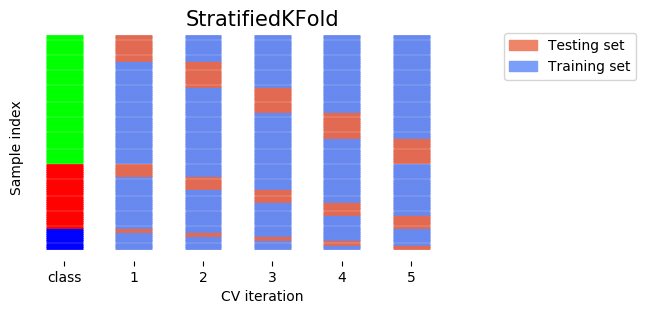

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = StratifiedKFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700)
ax.set_ylim((-6, 100));

### Leave-One-Out cross-validation

- _k_ fold cross-validation with _k_ equal to the number of samples
- Completely unbiased (in terms of data splits), but computationally expensive
- Actually generalizes _less_ well towards unseen data
    - The training sets are correlated (overlap heavily)
    - Overfits on the data used for (the entire) evaluation
    - A different sample of the data can yield different results
- Recommended only for small datasets

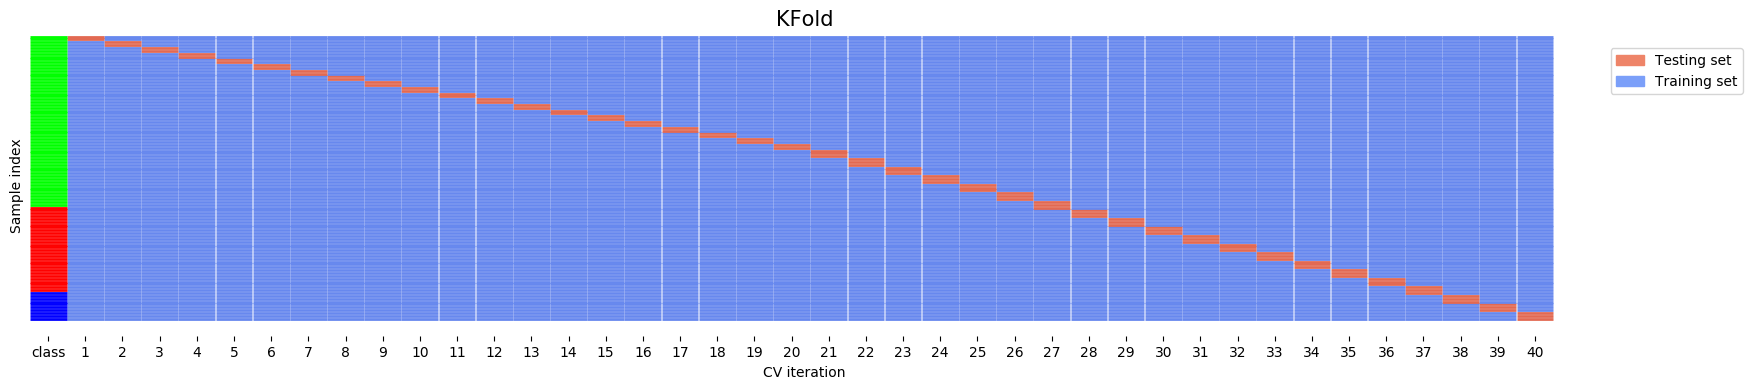

In [9]:
fig, ax = plt.subplots(figsize=(20, 4))
cv = KFold(40)
plot_cv_indices(cv, X, y, groups, ax, s=700)
ax.set_ylim((-6, 100));

### Shuffle-Split cross-validation
- Shuffles the data, samples (`train_size`) points randomly as the training set
- Can also use a smaller (`test_size`), handy with very large datasets
- Never use if the data is ordered (e.g. time series)

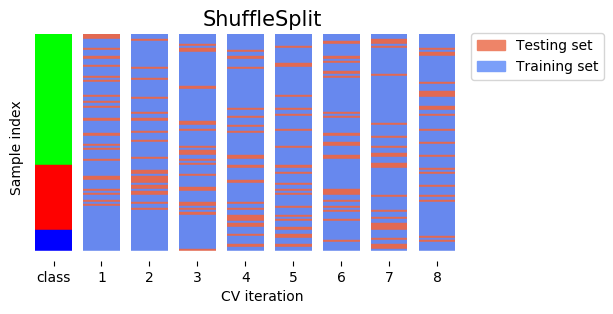

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = ShuffleSplit(8, test_size=.2)
plot_cv_indices(cv, X, y, groups, ax, n_splits, s=700)
ax.set_ylim((-6, 100))
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
          ['Testing set', 'Training set'], loc=(.95, .8));

### The Bootstrap
- Sample _n_ (total number of samples) data points, with replacement, as training set (the bootstrap)
    - On average, bootstraps include 66% of all data points (some are duplicates)
- Use the unsampled (out-of-bootstrap) samples as the test set
- Repeat $k$ times to obtain $k$ scores
- Similar to Shuffle-Split with `train_size=0.66`, `test_size=0.34` (without duplicates)

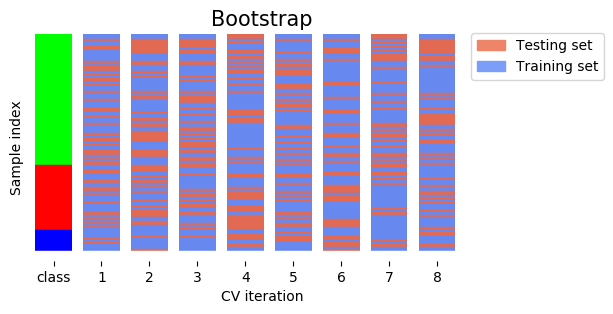

In [11]:
from sklearn.utils import resample

# Toy implementation of bootstrapping
class Bootstrap:
    def __init__(self, nr):
        self.nr = nr
    
    def get_n_splits(self, X, y, groups=None):
        return self.nr
    
    def split(self, X, y, groups=None):
        indices = range(len(X))
        splits = []
        for i in range(self.nr):
            train = resample(indices, replace=True, n_samples=len(X), random_state=i)
            test = list(set(indices) - set(train))
            splits.append((train, test))
        return splits
            
fig, ax = plt.subplots(figsize=(6, 3))
cv = Bootstrap(8)
plot_cv_indices(cv, X, y, groups, ax, n_splits, s=700)
ax.set_ylim((-6, 100))
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
          ['Testing set', 'Training set'], loc=(.95, .8));

### Repeated cross-validation
- Cross-validation is still biased in that the initial split can be made in many ways
- Repeated, or n-times-k-fold cross-validation:
    - Shuffle data randomly, do k-fold cross-validation
    - Repeat n times, yields n times k scores
- Unbiased, very robust, but n times more expensive

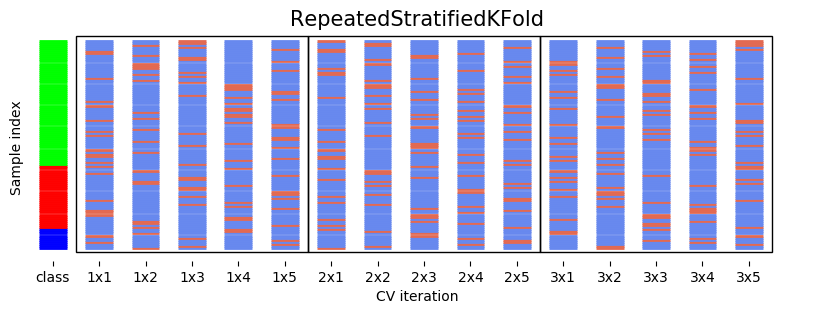

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(10, 3))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
plot_cv_indices(cv, X, y, groups, ax, lw=2, s=400, legend=False)
ax.set_ylim((-6, 102))
xticklabels = ["class"] + [f"{repeat}x{split}" for repeat in range(1, 4) for split in range(1, 6)]
ax.set_xticklabels(xticklabels)
for i in range(3):
    rect = Rectangle((-.5 + i * 5, -2.), 5, 103, edgecolor='k', facecolor='none')
    ax.add_artist(rect)

### Cross-validation with groups

- Sometimes the data contains inherent groups:
    - Multiple samples from same patient, images from same person,...
- With normal cross-validation, data from the same person may end up in the training _and_ test set
- We want to measure how well the model generalizes to _other_ people
- Make sure that data from one person are in _either_ the train or test set
    - This is called _grouping_ or _blocking_
    - Leave-one-subject-out cross-validation: test set for each subject/group

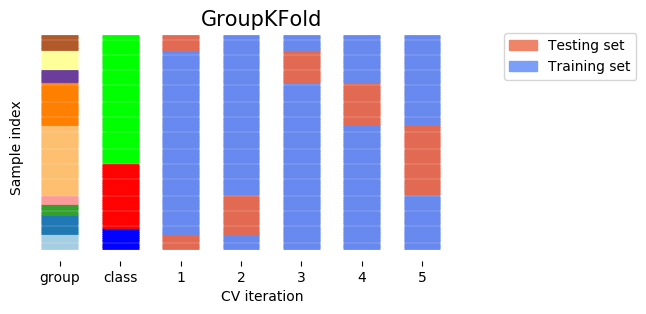

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
cv = GroupKFold(5)
plot_cv_indices(cv, X, y, groups, ax, s=700, show_groups=True)
ax.set_ylim((-6, 100));

### Time series
When the data is ordered, random test sets are not a good idea

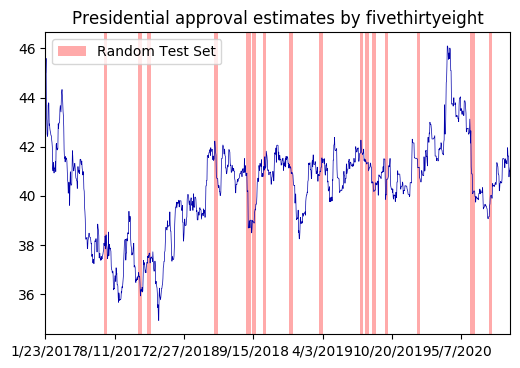

In [14]:
import pandas as pd
approval = pd.read_csv("https://projects.fivethirtyeight.com/trump-approval-data/approval_topline.csv")
adults = approval.groupby("subgroup").get_group('Adults')
adults = adults.set_index('modeldate')[::-1]
adults.approve_estimate.plot()
ax = plt.gca()
plt.rcParams["figure.figsize"] = [14,4]
ax.set_xlabel("")
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for i in range(20):
    rect = Rectangle((np.random.randint(0, xlim[1]), ylim[0]), 10, ylim[1]-ylim[0], facecolor='#FFAAAA')
    ax.add_artist(rect)
plt.title("Presidential approval estimates by fivethirtyeight")
plt.legend([rect], ['Random Test Set'] );

### Time series
* Test-then-train (prequential evaluation)
    * Every new sample is evaluated only once, then added to the training set
    * Can also be done in batches (of _n_ samples at a time) 
* `TimeSeriesSplit`
    * In the kth split, the first k folds are used as the train set and the (k+1)th fold as the test set
    * Can also be done with a maximum training set size: more robust against concept drift

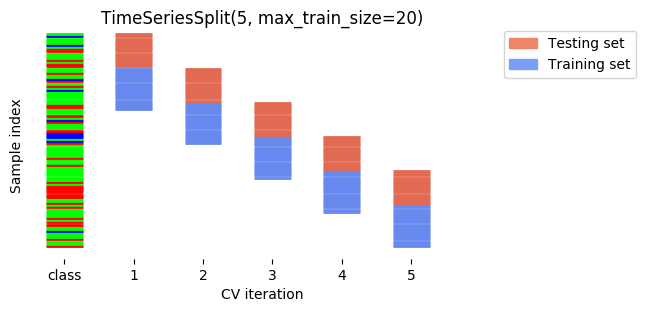

In [15]:
from sklearn.utils import shuffle
fig, ax = plt.subplots(figsize=(6, 3))
cv = TimeSeriesSplit(5, max_train_size=20)
plot_cv_indices(cv, X, shuffle(y), groups, ax, s=700, lw=2)
ax.set_ylim((-6, 100))
ax.set_title("TimeSeriesSplit(5, max_train_size=20)");

### Choosing a performance estimation procedure
No strict rules, only guidelines:

- Always use stratification for classification (sklearn does this by default)
- Use holdout for very large datasets (e.g. >1.000.000 examples)
    - Or when learners don't always converge (e.g. deep learning)
- Choose _k_ depending on dataset size and resources
    - Use leave-one-out for very small datasets (e.g. <100 examples)
    - Use cross-validation otherwise
        - Most popular (and theoretically sound): 10-fold CV
        - Literature suggests 5x2-fold CV is better
- Use grouping or leave-one-subject-out for grouped data
- Use train-then-test for time series

# Evaluation Metrics

### Evaluation vs Optimization

- Each algorithm optimizes a given objective function (on the training data)
    - E.g. remember L2 loss in Ridge regression
$$\mathcal{L}_{Ridge} = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 + \alpha \sum_{i=0}^{p} w_i^2$$ 
- The choice of function is limited by what can be efficiently optimized
    - E.g. gradient descent requires a differentiable loss function
- However, we _evaluate_ the resulting model with a score that makes sense **in the real world**
    - Percentage of correct predictions (on a test set)
    - The actual cost of mistakes (e.g. in money, time, lives,...)
- We also tune the algorithm's hyperparameters to maximize that score

### Binary classification

- We have a positive and a negative class
- 2 different kind of errors:
    - False Positive (type I error): model predicts positive while the true label is negative
    - False Negative (type II error): model predicts negative while the true label is positive
- They are not always equally important
    - Which side do you want to err on for a medical test?

<img src="../images/type1error.jpg" alt="ml" style="width: 600px;"/>


#### Confusion matrices
- We can represent all predictions (correct and incorrect) in a confusion matrix
    - n by n array (n is the number of classes)
    - Rows correspond to true classes, columns to predicted classes
    - Count how often samples belonging to a class C are classified as C or any other class.
    - For binary classification, we label these true negative (TN), true positive (TP), false negative (FN), false positive (FP)

| | Predicted Pos | Predicted Neg |
|-|-|-|
| Actual Pos | TP | FN |
| Actual Neg | FP | TN |

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, stratify=data.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("confusion_matrix(y_test, y_pred): \n", confusion_matrix(y_test, y_pred))

confusion_matrix(y_test, y_pred): 
 [[48  5]
 [ 5 85]]


#### Predictive accuracy

- Accuracy can be computed based on the confusion matrix
- Not useful if the dataset is very imbalanced
    - E.g. credit card fraud: is 99.99% accuracy good enough? 

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

- 3 models: very different predictions, same accuracy:

In [17]:
# From Applied Machine Learning
def plot_confusion_matrix(values, xlabel="predicted labels", ylabel="true labels", xticklabels=None,
                          yticklabels=None, cmap=None, vmin=None, vmax=None, ax=None,
                          fmt="{:.2f}", xtickrotation=45, norm=None, fsize=8):
    """Plot a matrix as heatmap with explicit numbers.
    Parameters
    ----------
    values : ndarray
        Two-dimensional array to visualize.
    xlabel : string, default=""
        Label for the x-axis.
    ylabel : string, default=""
        Label for the y-axis.
    xticklabels : list of string or None, default=None
        Tick labels for the x-axis.
    yticklabels : list of string or None, default=None
        Tick labels for the y-axis
    cmap : string or colormap
        Matpotlib colormap to use.
    vmin : int, float or None
        Minimum clipping value.
    vmax : int, float or None
        Maximum clipping value.
    ax : axes object or None
        Matplotlib axes object to plot into. If None, the current axes are
        used.
    fmt : string, default="{:.2f}"
        Format string to convert value to text.
    xtickrotation : float, default=45
        Rotation of the xticklabels.
    norm : matplotlib normalizer
        Normalizer passed to pcolor
    """
    import matplotlib.pyplot as plt
    plt.gcf().set_size_inches(fsize, fsize)
    if ax is None:
        ax = plt.gca()
    img = ax.pcolormesh(values, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    # this will allow us to access the pixel values:
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xlim(0, values.shape[1])
    ax.set_ylim(0, values.shape[0])

    if xticklabels is None:
        xticklabels = [""] * values.shape[1]
    if yticklabels is None:
        yticklabels = [""] * values.shape[0]

    # +.5 makes the ticks centered on the pixels
    ax.set_xticks(np.arange(values.shape[1]) + .5)
    ax.set_xticklabels(xticklabels, ha="center", rotation=xtickrotation)
    ax.set_yticks(np.arange(values.shape[0]) + .5)
    ax.set_yticklabels(yticklabels, va="center")
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            # pixel brightness: use black for number
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt.format(value), color=c, ha="center", va="center")
    ax.invert_yaxis()
    return ax

In [18]:
# Artificial 90-10 imbalanced target
y_true = np.zeros(100, dtype=int)
y_true[:10] = 1
y_pred_1 = np.zeros(100, dtype=int)
y_pred_2 = y_true.copy()
y_pred_2[10:20] = 1
y_pred_3 = y_true.copy()
y_pred_3[5:15] = 1 - y_pred_3[5:15]

def plot_measure(measure):
    fig, axes = plt.subplots(1, 3)
    for i, (ax, y_pred) in enumerate(zip(axes, [y_pred_1, y_pred_2, y_pred_3])):
        plot_confusion_matrix(confusion_matrix(y_true, y_pred), cmap='gray_r', ax=ax,
                              xticklabels=["N", "P"], yticklabels=["N", "P"], xtickrotation=0, vmin=0, vmax=100)
        ax.set_title("{}: {:.2f}".format(measure.__name__,measure(y_true, y_pred)))

    plt.tight_layout()

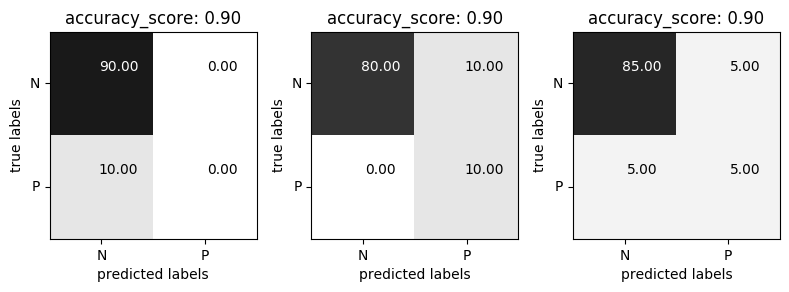

In [19]:
plot_measure(accuracy_score)

#### Precision
- Use when the goal is to limit FPs
    - Clinical trails: you only want to test drugs that really work
    - Search engines: you want to avoid bad search results

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

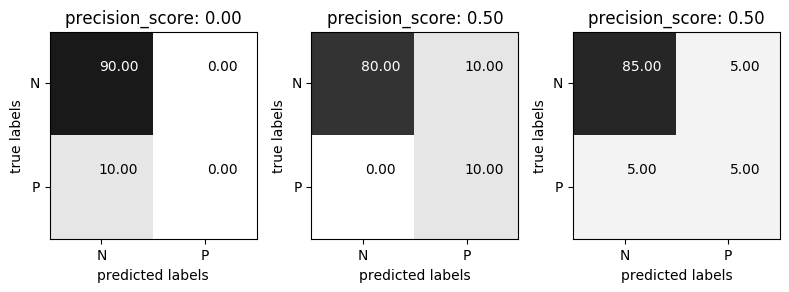

In [20]:
from sklearn.metrics import precision_score
plot_measure(precision_score)

#### Recall
- Use when the goal is to limit FNs
    - Cancer diagnosis: you don't want to miss a serious disease
    - Search engines: You don't want to omit important hits
- Also know as sensitivity, hit rate, true positive rate (TPR)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

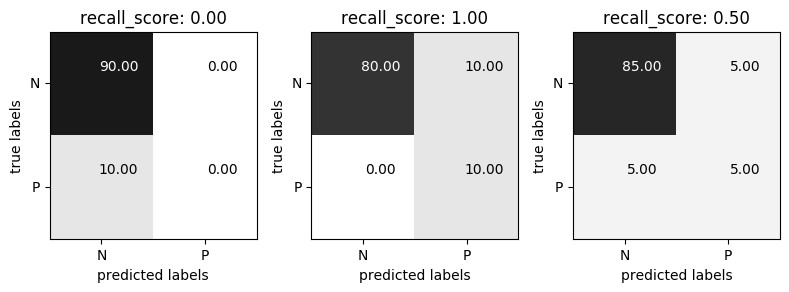

In [21]:
from sklearn.metrics import recall_score
plot_measure(recall_score)

__Comparison__   
<img src="../images/07_precision-recall.jpg" alt="ml" style="width: 600px;"/>

#### F1-score
- Trades off precision and recall:

\begin{equation}
\text{F1} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

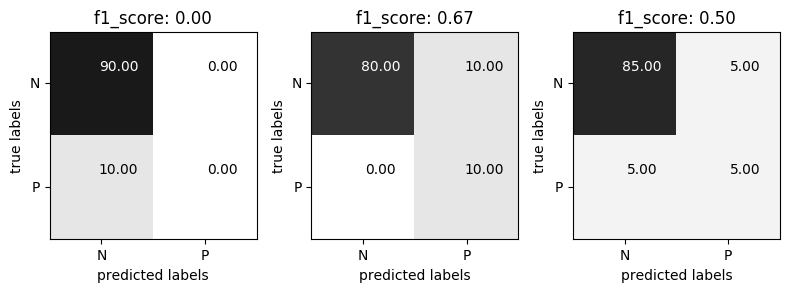

In [22]:
from sklearn.metrics import f1_score
plot_measure(f1_score)

__Classification measure Zoo__   
![](../images/07_zoo.png)
https://en.wikipedia.org/wiki/Precision_and_recall

### Multi-class classification
- Train models _per class_ : one class viewed as positive, other(s) als negative. Then, average scores over classes.
    - micro-averaging: count total TP, FP, TN, FN 
        - Each sample is equally important, irrespective of class
        - micro-precision, micro-recall, micro-F1, accuracy are all the same
        $$\text{micro-precision} = \frac{\sum_{c=1}^C\text{TP}_c}{\sum_{c=1}^C\text{TP}_c + \sum_{c=1}^C\text{FP}_c} \xrightarrow{c=2} \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$
    - macro-averaging: average of scores $R(y_c,\hat{y_c})$ obtained on each class
        - Preferable for imbalanced classes (if all classes are equally important)
        - macro-averaged recall is also called _balanced accuracy_ 
         $$\frac{1}{C} \sum_{c=1}^C R(y_c,\hat{y_c})$$
    - weighted averaging ($w_c$: ratio of examples of class $c$, aka support) $$\sum_{c=1}^C w_c R(y_c,\hat{y_c})$$

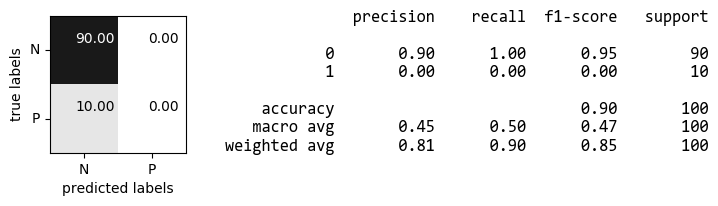

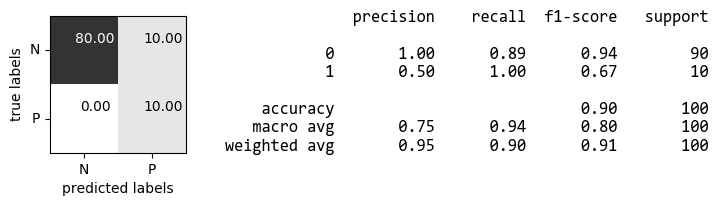

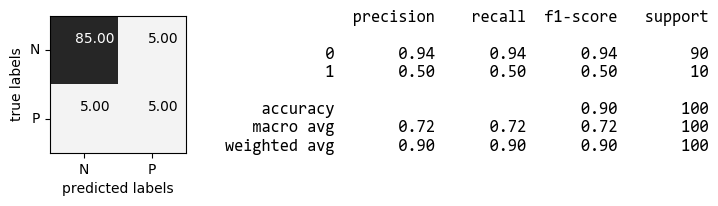

In [23]:
from sklearn.metrics import classification_report

def report(y_pred):
    fig = plt.figure()
    ax = plt.subplot(111)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), cmap='gray_r', ax=ax,
                          xticklabels=["N", "P"], yticklabels=["N", "P"], xtickrotation=0, vmin=0, vmax=100, fsize=2.1)
    plt.gcf().text(1.1, 0.2, classification_report(y_true, y_pred), fontsize=12, fontname="Consolas")

    plt.tight_layout()
report(y_pred_1)
report(y_pred_2)
report(y_pred_3)

## Probabilistic evaluation measures
* Classifiers can often provide uncertainty estimates of predictions.  
* Remember that linear models actually return a numeric value.
    - When $\hat{y}<0$, predict class -1, otherwise predict class +1
    $$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b $$  
* In practice, you are often interested in how certain a classifier is about each class prediction (e.g. cancer treatments).  
* Most learning methods can return at least one measure of _confidence_ in their predicions.
    - Decision function: floating point value for each sample (higher: more confident)
    - Probability: estimated probability for each class

### The decision function
In the binary classification case, the return value of the decision function encodes how strongly the model believes a data point 
belongs to the “positive” class.  
- Positive values indicate preference for the positive class. 
- The range can be arbitrary, and can be affected by hyperparameters. Hard to interpret.

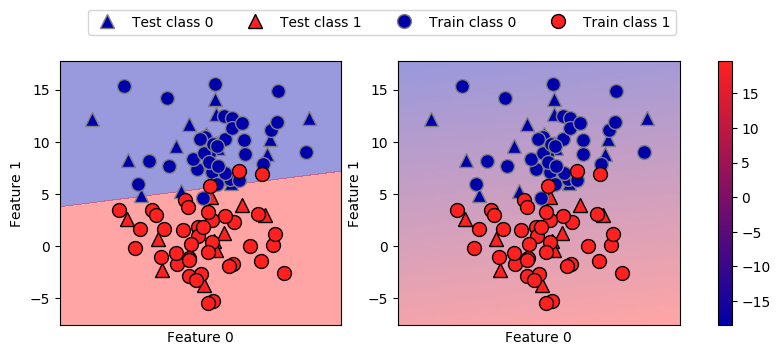

In [24]:
# create and split a synthetic dataset
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
Xs, ys = make_blobs(centers=2, cluster_std=2.5, random_state=8)

# we rename the classes "blue" and "red"
ys_named = np.array(["blue", "red"])[ys]

# we can call train test split with arbitrary many arrays
# all will be split in a consistent manner
Xs_train, Xs_test, ys_train_named, ys_test_named, ys_train, ys_test = \
    train_test_split(Xs, ys_named, ys, random_state=0)

# build the logistic regression model
lr = LogisticRegression()
lr.fit(Xs_train, ys_train_named)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
    
mglearn.tools.plot_2d_separator(lr, Xs, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(lr, Xs, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(Xs_test[:, 0], Xs_test[:, 1], ys_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(Xs_train[:, 0], Xs_train[:, 1], ys_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));  

### Predicting probabilities
Some models can also return a _probability_ for each class with every prediction. These sum up to 1.
We can visualize them again. Note that the gradient looks different now.

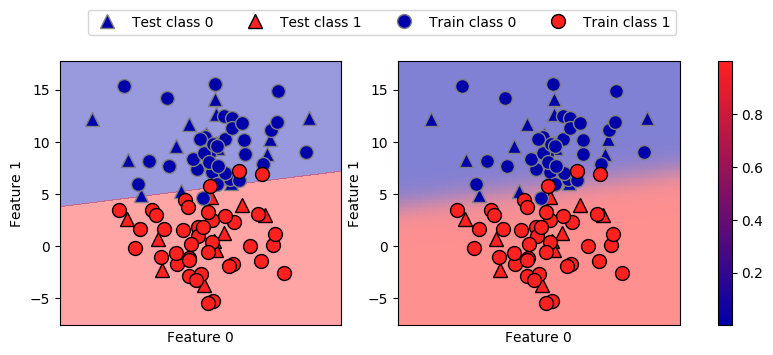

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
    
mglearn.tools.plot_2d_separator(
    lr, Xs, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    lr, Xs, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(Xs_test[:, 0], Xs_test[:, 1], ys_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(Xs_train[:, 0], Xs_train[:, 1], ys_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
# don't want a transparent colorbar
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1));

## Threshold calibration

- By default, we threshold at 0 for  `decision_function` and 0.5 for `predict_proba`
- Depending on the application, you may want to threshold differently
    - Lower threshold yields fewer FN (better recall), more FP (worse precision), and vice-versa

In [26]:
from mglearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from mglearn.tools import plot_2d_separator, plot_2d_scores, cm, discrete_scatter
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Xs, ys = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],
                    random_state=22)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, stratify=ys, random_state=0)
svc = SVC(gamma=.04).fit(Xs_train, ys_train)
    
    
@interact
def plot_decision_threshold(threshold=(-1.2,1.3,0.1)):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.2), subplot_kw={'xticks': (), 'yticks': ()})    
    line = np.linspace(Xs_train.min(), Xs_train.max(), 100)

    axes[0].set_title("decision with threshold {:.2f}".format(threshold))
    discrete_scatter(Xs_train[:, 0], Xs_train[:, 1], ys_train, ax=axes[0])
    discrete_scatter(Xs_test[:, 0], Xs_test[:, 1], ys_test, ax=axes[0], markers='^')

    plot_2d_scores(svc, Xs_train, function="decision_function", alpha=.7,
                   ax=axes[0], cm=mglearn.ReBl)
    plot_2d_separator(svc, Xs_train, linewidth=3, ax=axes[0], threshold=threshold)
    axes[0].set_xlim(Xs_train[:, 0].min(), Xs_train[:, 0].max())
    axes[0].plot(line, np.array([10 for i in range(len(line))]), 'k:', linewidth=2)

    axes[1].set_title("cross-section with threshold {:.2f}".format(threshold))
    axes[1].plot(line, svc.decision_function(np.c_[line, 10 * np.ones(100)]), c='k')
    dec = svc.decision_function(np.c_[line, 10 * np.ones(100)])
    contour = (dec > threshold).reshape(1, -1).repeat(10, axis=0)
    axes[1].contourf(line, np.linspace(-1.5, 1.5, 10), contour, linewidth=2, alpha=0.4, cmap=cm)
    discrete_scatter(Xs_test[:, 0], Xs_test[:, 1]*0, ys_test, ax=axes[1], markers='^')

    axes[1].plot(line, np.array([threshold for i in range(len(line))]), 'r:', linewidth=3)
    
    
    axes[0].set_xlim(Xs_train[:, 0].min(), Xs_train[:, 0].max())
    axes[1].set_xlim(Xs_train[:, 0].min(), Xs_train[:, 0].max())
    axes[1].set_ylim(-1.5, 1.5)
    axes[1].set_xticks(())
    axes[1].set_yticks(np.arange(-1.5, 1.5, 0.5))
    axes[1].yaxis.tick_right()
    axes[1].set_ylabel("Decision value")
    
    y_pred = svc.decision_function(Xs_test)
    y_pred = y_pred > threshold
    axes[1].text(Xs_train.min()+1,1.2,"Precision: {:.4f}".format(precision_score(ys_test,y_pred)))
    axes[1].text(Xs_train.min()+1,0.9,"Recall: {:.4f}".format(recall_score(ys_test,y_pred)))
    plt.tight_layout();

interactive(children=(FloatSlider(value=2.220446049250313e-16, description='threshold', max=1.3, min=-1.2), Ou…

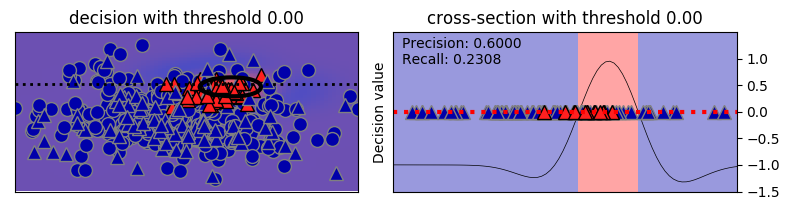

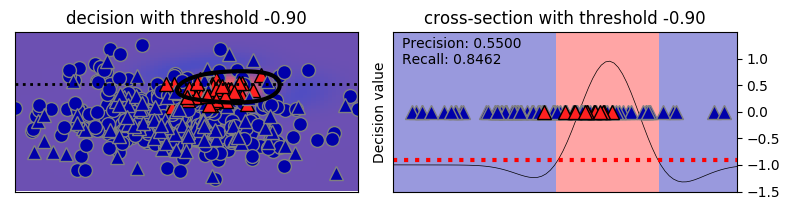

In [27]:
if not interactive:
    plot_decision_threshold(0)
    plot_decision_threshold(-0.9)

### Precision-Recall curve
- The best trade-off between precision and recall depends on your application
    - You can have arbitrary high recall, but you often want reasonable precision, too.
- Plotting precision against recall _for all possible thresholds_ yields a __precision-recall curve__
    - Change the treshold until you find a sweet spot in the precision-recall trade-off
    - Often jagged at high thresholds, when there are few positive examples left

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

# create a similar dataset as before, but with more samples
# to get a smoother curve
Xp, yp = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2], random_state=22)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, random_state=0)
svc = SVC(gamma=.05).fit(Xp_train, yp_train)
rf = RandomForestClassifier(n_estimators=100).fit(Xp_train, yp_train)

@interact
def plot_PR_curve(threshold=(-3.19,1.4,0.1), model=[svc, rf]):
    if hasattr(model, "predict_proba"):
        precision, recall, thresholds = precision_recall_curve(
            yp_test, model.predict_proba(Xp_test)[:, 1])
    else:
        precision, recall, thresholds = precision_recall_curve(
            yp_test, model.decision_function(Xp_test))
    # find existing threshold closest to zero
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
             label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.plot(recall, precision, lw=2, label="precision recall curve")

    if hasattr(model, "predict_proba"):
        yp_pred = model.predict_proba(Xp_test)[:, 1] > threshold
    else:
        yp_pred = model.decision_function(Xp_test) > threshold
    plt.plot(recall_score(yp_test,yp_pred), precision_score(yp_test,yp_pred), 'o', markersize=10, label="threshold {:.2f}".format(threshold))

    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc="best");

interactive(children=(FloatSlider(value=-0.9899999999999998, description='threshold', max=1.4, min=-3.19), Dro…

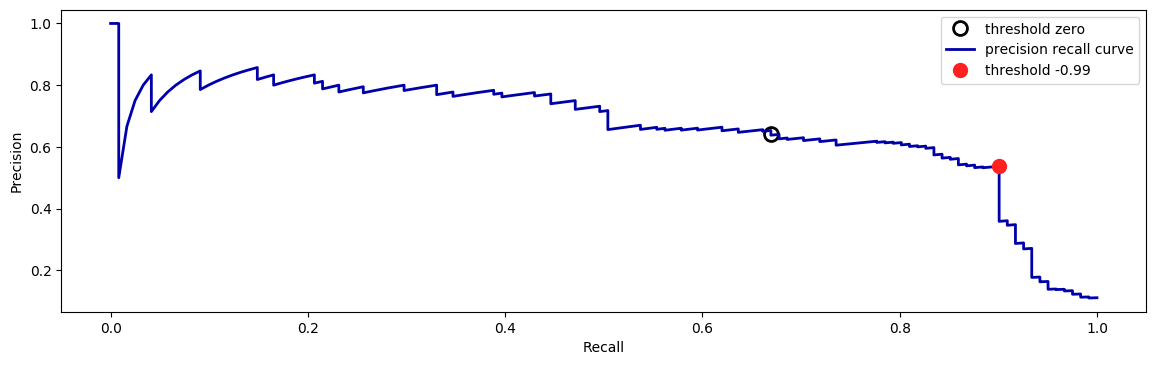

In [29]:
if not interactive:
    plot_PR_curve(threshold=-0.99,model=svc)

### Model selection
- Some models can achieve trade-offs that others can't
- Your application may require very high recall (or very high precision)
    - Choose the model that offers the best trade-off, given your application
- The area under the PR curve (AUPRC) gives the _best overall_ model

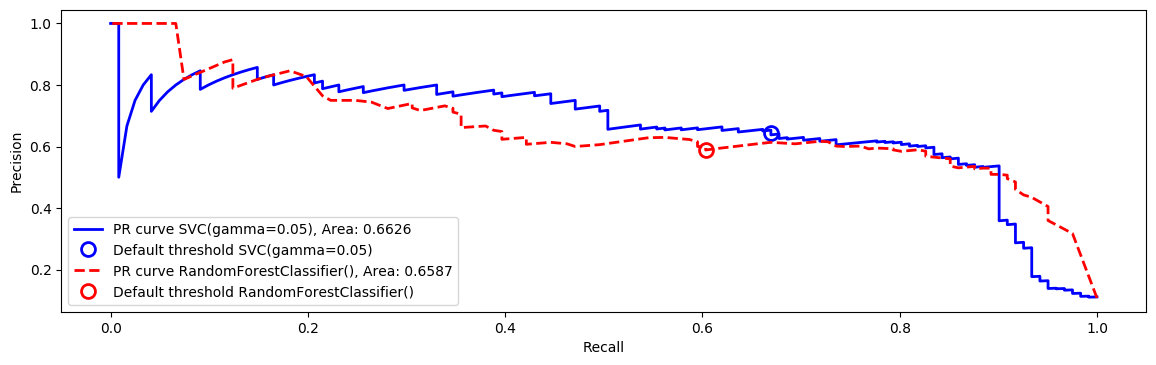

In [30]:
from sklearn.metrics import auc
colors=['b','r','g','y']

def plot_PR_curves(models):
    for i, model in enumerate(models):
        if hasattr(model, "predict_proba"):
            precision, recall, thresholds = precision_recall_curve(
                yp_test, model.predict_proba(Xp_test)[:, 1])
            close_zero = np.argmin(np.abs(thresholds-0.5))
        else:
            precision, recall, thresholds = precision_recall_curve(
                yp_test, model.decision_function(Xp_test))
            close_zero = np.argmin(np.abs(thresholds))
        plt.plot(recall, precision, lw=2, c=colors[i], label="PR curve {}, Area: {:.4f}".format(model, auc(recall, precision))) 
        plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
                 fillstyle="none", c=colors[i], mew=2, label="Default threshold {}".format(model))
        plt.ylabel("Precision")
        plt.xlabel("Recall")
        plt.legend(loc="lower left");
        
#svc2 = SVC(gamma=0.01).fit(X_train, y_train)
plot_PR_curves([svc, rf])

#### Hyperparameter effects
Of course, hyperparameters affect predictions and hence also the shape of the curve

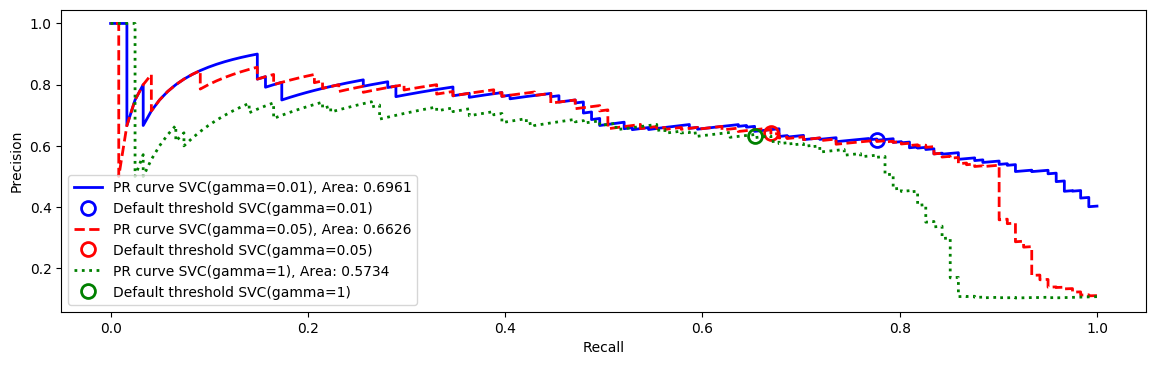

In [31]:
svc2 = SVC(gamma=0.01).fit(Xp_train, yp_train)
svc3 = SVC(gamma=1).fit(Xp_train, yp_train)
plot_PR_curves([svc2, svc, svc3])

### Receiver Operating Characteristics (ROC)

- We can also trade off recall (aka true positive rate) $\textit{TPR}= \frac{TP}{TP + FN}$ with _false positive rate_ $\textit{FPR} = \frac{FP}{FP + TN}$
- Plotting TPR against FPR _for all possible thresholds_ yields a _Receiver Operating Characteristics curve_
    - Change the treshold until you find a sweet spot in the TPR-FPR trade-off
    - Lower thresholds yield higher TPR (recall), lower FPR, and vice versa

In [32]:
from sklearn.metrics import roc_curve

@interact
def plot_ROC_curve(threshold=(-3.19,1.4,0.1), model=[svc, rf]):
    if hasattr(model, "predict_proba"):
        fpr, tpr, thresholds = roc_curve(yp_test, model.predict_proba(Xp_test)[:, 1])
    else:
        fpr, tpr, thresholds = roc_curve(yp_test, model.decision_function(Xp_test))
    # find existing threshold closest to zero
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.plot(fpr, tpr, lw=2, label="ROC curve")
    
    closest = np.argmin(np.abs(thresholds-threshold))
    plt.plot(fpr[closest], tpr[closest], 'o', markersize=10, label="threshold {:.2f}".format(threshold))
    
    plt.ylabel("TPR (recall)")
    plt.xlabel("FPR")
    plt.legend(loc="best");

interactive(children=(FloatSlider(value=-0.9899999999999998, description='threshold', max=1.4, min=-3.19), Dro…

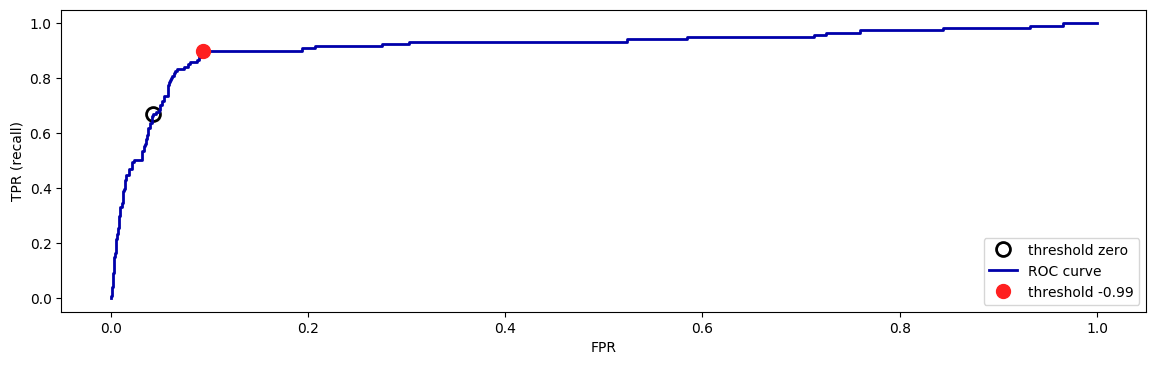

In [33]:
if not interactive:
    plot_ROC_curve(threshold=-0.99,model=svc)

#### Visualization
* Histograms show the amount of points with a certain decision value (for each class)
* $\textit{TPR}= \frac{\color{red}{TP}}{\color{red}{TP} + \color{magenta}{FN}}$ can be seen from the positive predictions (top histogram)
* $\textit{FPR} = \frac{\color{cyan}{FP}}{\color{cyan}{FP} + \color{blue}{TN}}$  can be seen from the negative predictions (bottom histogram)

In [34]:
# More data for a smoother curve
Xb, yb = make_blobs(n_samples=(4000, 4000), centers=2, cluster_std=[3, 3], random_state=7)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, random_state=0)
svc_roc = SVC(C=2).fit(Xb_train, yb_train)
probs = svc_roc.decision_function(Xb_test)

@interact
def plot_roc_threshold(threshold=(-2,2,0.1)):
    fig = plt.figure(constrained_layout=True)
    axes = []
    gs = fig.add_gridspec(2, 2)
    axes.append(fig.add_subplot(gs[0, :-1]))
    axes.append(fig.add_subplot(gs[1, :-1]))
    axes.append(fig.add_subplot(gs[:, 1]))
    
    n=50 # number of histogram bins
    color=['b','r']
    color_fill=['b','c','m','r']
    labels=['TN','FP','FN','TP']
    
    # Histograms
    for label in range(2):
        ps = probs[yb_test == label] # get prediction for given label
        p, x = np.histogram(ps, bins=n) # bin it into n bins
        x = x[:-1] + (x[1] - x[0])/2 # convert bin edges to center
        axes[1-label].plot(x, p, c=color[label], lw=2)
        axes[1-label].fill_between(x[x<threshold], p[x<threshold], -5, facecolor=color_fill[2*label], label='{}: {}'.format(labels[2*label],np.sum(p[x<threshold])))
        axes[1-label].fill_between(x[x>=threshold], p[x>threshold], -5, facecolor=color_fill[2*label+1], label='{}: {}'.format(labels[2*label+1],np.sum(p[x>=threshold])))
        axes[1-label].set_title('Histogram of decision values for points with class {}'.format(label))
        axes[1-label].legend()
        
    #ROC curve
    fpr, tpr, thresholds = roc_curve(yb_test, svc_roc.decision_function(Xb_test))
    axes[2].plot(fpr, tpr, lw=2, label="ROC curve", c='k')
    closest = np.argmin(np.abs(thresholds-threshold))
    axes[2].plot(fpr[closest], tpr[closest], 'o', markersize=10, label="threshold {:.2f}".format(threshold))
    
    axes[2].set_title('ROC curve')
    axes[2].set_xlabel("FPR")
    axes[2].set_ylabel("TPR")
    axes[2].legend()

interactive(children=(FloatSlider(value=0.0, description='threshold', max=2.0, min=-2.0), Output()), _dom_clas…

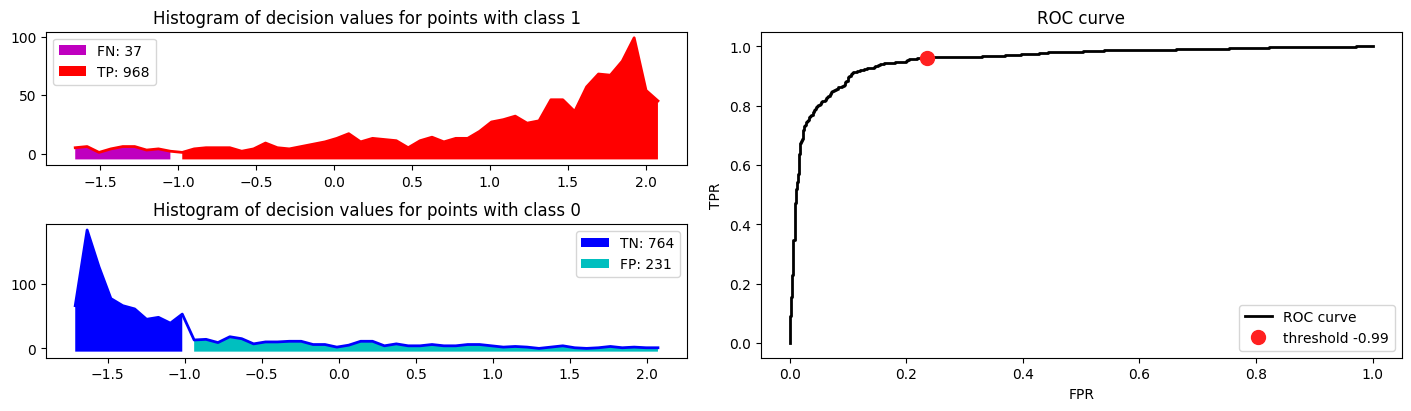

In [35]:
if not interactive:
    plot_roc_threshold(threshold=-0.99)

### Model selection
- Again, some models can achieve trade-offs that others can't
- Your application may require minizing FPR (low FP), or maximizing TPR (low FN)
- The area under the ROC curve (AUROC or AUC) gives the _best overall_ model
    - Frequently used for evaluating models on imbalanced data
    - Random guessing (TPR=FPR) or predicting majority class (TPR=FPR=1): 0.5 AUC

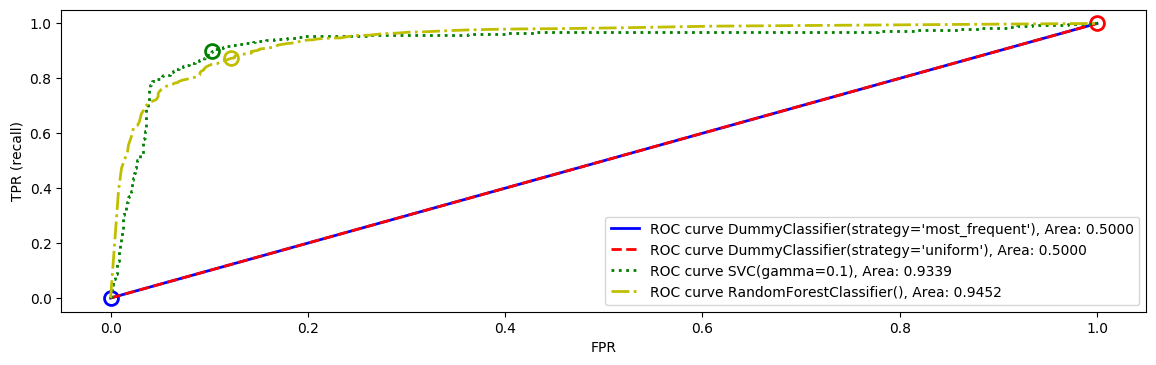

In [36]:
from sklearn.metrics import auc
from sklearn.dummy import DummyClassifier

def plot_ROC_curves(models):
    for i, model in enumerate(models):
        if hasattr(model, "predict_proba"):
            fpr, tpr, thresholds = roc_curve(
                yb_test, model.predict_proba(Xb_test)[:, 1])
            close_zero = np.argmin(np.abs(thresholds-0.5))
        else:
            fpr, tpr, thresholds = roc_curve(
                yb_test, model.decision_function(Xb_test))
            close_zero = np.argmin(np.abs(thresholds))
        plt.plot(fpr, tpr, lw=2, c=colors[i], label="ROC curve {}, Area: {:.4f}".format(model, auc(fpr, tpr))) 
        plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
                 fillstyle="none", c=colors[i], mew=2) #label="Default threshold {}".format(model)
        plt.ylabel("TPR (recall)")
        plt.xlabel("FPR")
        plt.legend(loc="lower right");
        
svc = SVC(gamma=.1).fit(Xb_train, yb_train)
rf = RandomForestClassifier(n_estimators=100).fit(Xb_train, yb_train)
dc = DummyClassifier(strategy='most_frequent').fit(Xb_train, yb_train)
dc2 = DummyClassifier(strategy='uniform').fit(Xb_train, yb_train)
plot_ROC_curves([dc, dc2, svc, rf])

### Multi-class AUROC (or AUPRC) 
* We again need to choose between micro- or macro averaging TPR and FPR.
    * Micro-average if every sample is equally important (irrespective of class)
    * Macro-average if every class is equally important, especially for imbalanced data

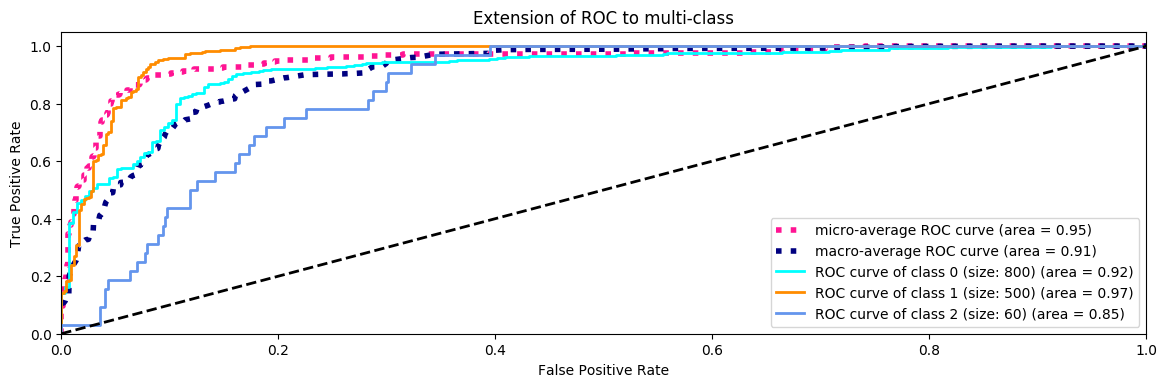

In [37]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# 3 class imbalanced data
Xi, yi = make_blobs(n_samples=(800, 500, 60), centers=3, cluster_std=[7.0, 2, 3.0], random_state=22)
sizes = [800, 500, 60]

# Binarize the output
yi = label_binarize(yi, classes=[0, 1, 2])
n_classes = yi.shape[1]
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(probability=True))
y_score = classifier.fit(Xi_train, yi_train).decision_function(Xi_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yi_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yi_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, linestyle='-',
             label='ROC curve of class {} (size: {}) (area = {:0.2f})'
             ''.format(i, sizes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of ROC to multi-class')
plt.legend(loc="lower right")
plt.show()

### Cost-sensitive classification
* There are several ways to include misclassification costs
* Cost-sensitive resampling
    - resample (or reweight) the data to meet real-world costs, when data is not representative
    - oversample minority classes, or undersample majority classes to 'correct' imbalanced data
    - increase weight of previously misclassified samples (e.g. in boosting)
    - decrease weight of previously misclassified (noisy?) samples (e.g. in model compression)
* Cost-sensitive algorithms
    - If misclassification cost of some classes is higher, we can give them higher weights
    - Some implementations support _cost matrix_ $C$: costs $c_{i,j}$ for every possible type of error
* Cost-sensitive ensembles: convert cost-insensitive classifiers into cost-sensitive ones
    - MetaCost: Build a model (usually an ensemble) to learn the class probabilities $P(j|x)$
        - Relabel training data to minimize expected cost: $\underset{i}{\operatorname{argmin}} \sum_j P_j(x) c_{i,j}$
        - Accuracy may decrease but cost decreases as well.
    - AdaCost: Boosting algorithm that reweights instances every iteration to reduce costs

### Instance weighting
* If some _training instances_ are important to get right, we can give them more weight
    * E.g. when some examples are from groups underrepresented in the data
* These are passed during training (fit), and included in the loss function
    * E.g. Logistic regression: add a instance weight $w_n$ in the log loss function
$$\mathcal{L_{log}}(\mathbf{w}) = - \sum_{c=1}^{C} \sum_{n=1}^{N} \color{red}{w_n} p_{n,c} log(q_{n,c}) $$

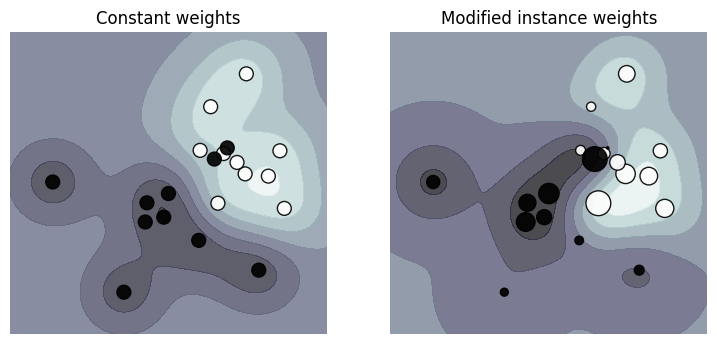

In [38]:
def plot_decision_function(classifier, X, y, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, 500), np.linspace(np.min(X[:,1])-1, np.max(X[:,1])+1, 500))
    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)

# Example from https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html
def plot_instance_weights():
    np.random.seed(0)
    X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
    y = [1] * 10 + [-1] * 10
    sample_weight_last_ten = abs(np.random.randn(len(X)))
    sample_weight_constant = np.ones(len(X))
    # and bigger weights to some outliers
    sample_weight_last_ten[15:] *= 5
    sample_weight_last_ten[9] *= 15

    # for reference, first fit without sample weights

    # fit the model
    clf_weights = SVC(gamma=1)
    clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

    clf_no_weights = SVC(gamma=1)
    clf_no_weights.fit(X, y)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    plot_decision_function(clf_no_weights, X, y, sample_weight_constant, axes[0],
                           "Constant weights")
    plot_decision_function(clf_weights, X, y, sample_weight_last_ten, axes[1],
                           "Modified instance weights")
plot_instance_weights()   

### Class weighting
* If some classes are more important than others, we can give them more weight
    * E.g. for imbalanced data, we can give more weight to minority classes
* Most classification models can include it in their loss function and optimize for it
    * E.g. Logistic regression: add a class weight $w_c$ in the log loss function
$$\mathcal{L_{log}}(\mathbf{w}) = - \sum_{c=1}^{C} \color{red}{w_c} \sum_{n=1}^{N} p_{n,c} log(q_{n,c}) $$

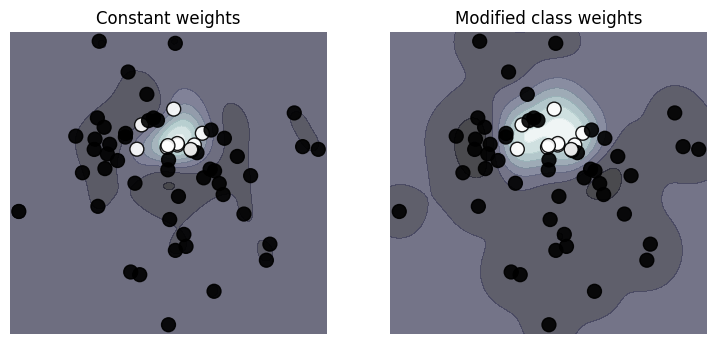

In [39]:
def plot_class_weights():
    X, y = make_blobs(n_samples=(50, 10), centers=2, cluster_std=[7.0, 2], random_state=4)
    
    # fit the models
    clf_weights = SVC(gamma=0.1, C=0.1, class_weight={1: 10}).fit(X, y)
    clf_no_weights = SVC(gamma=0.1, C=0.1).fit(X, y)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    plot_decision_function(clf_no_weights, X, y, 1, axes[0],
                           "Constant weights")
    plot_decision_function(clf_weights, X, y, 1, axes[1],
                           "Modified class weights")
plot_class_weights()

### Tuning the decision threshold to optimize costs
- If every FP or FN has a certain _cost_, we can compute the total cost for a given model:
$$\text{total cost} = \text{FPR} * cost_{FP} * ratio_{pos} + (1-\text{TPR}) *  cost_{FN} * (1-ratio_{pos})$$
- This yields different _isometrics_ (lines of equal cost) in ROC space
- The optimal threshold is the point on the ROC curve where the cost is minimal (line search)

In [40]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Cost function
def cost(fpr, tpr, cost_FN, cost_FP, ratio_P):
    return fpr * cost_FP + (1 - tpr) * cost_FN;

@interact
def plot_isometrics(c_FN=(1,10.0,1.0), c_FP=(1,10.0,1.0)):
    plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(yb_test, svc.decision_function(Xb_test))

    # get minimum
    ratio_P = len(yb_test[yb_test==1]) / len(yp_test)
    costs = [cost(fpr[x],tpr[x],c_FN,c_FP, ratio_P) for x in range(len(thresholds))]
    min_cost = np.min(costs)
    min_thres = np.argmin(costs)

    # plot contours
    x = np.arange(0.0, 1.1, 0.1)
    y = np.arange(0.0, 1.1, 0.1)
    XX, YY = np.meshgrid(x, y)
    costs = [cost(f, t, c_FN, c_FP, ratio_P) for f, t in zip(XX,YY)]

    fig, axes = plt.subplots(1, 1, figsize=(9, 3))
    plt.plot(fpr, tpr, label="ROC Curve")
    levels = np.linspace(np.array(costs).min(), np.array(costs).max(), 10)
    levels = np.sort(np.append(levels, min_cost))
    CS = plt.contour(XX, YY, costs, levels)
    plt.clabel(CS, inline=1, fontsize=10)

    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    # find threshold closest to zero:
    plt.plot(fpr[min_thres], tpr[min_thres], 'o', markersize=4,
             label="optimal", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);
    plt.title("Isometrics, cost_FN: {}, cost_FP: {}".format(c_FN, c_FP))
    plt.show()

interactive(children=(FloatSlider(value=5.0, description='c_FN', max=10.0, min=1.0, step=1.0), FloatSlider(val…

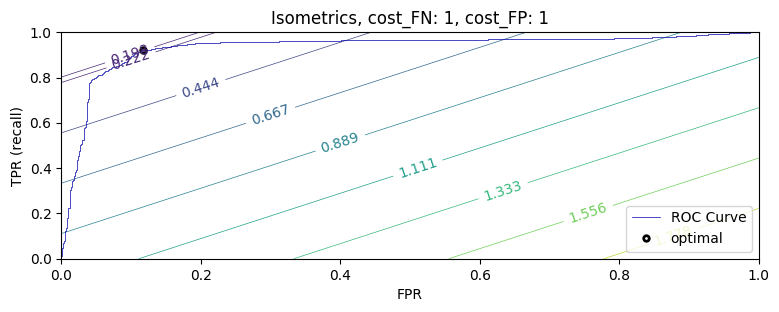

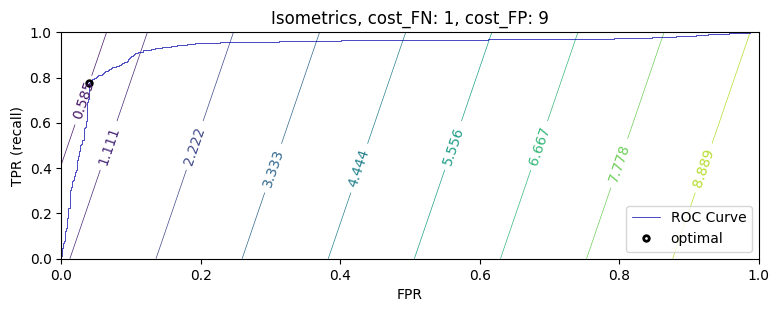

In [41]:
if not interactive:
    plot_isometrics(1,1)
    plot_isometrics(1,9)

## Using class confidences, Brier score
* You may want to use the predicted class confidence (e.g. class probability) to make decisions
* Select models based on how accurate the class confidences are.
    * SVM and RandomForest are know to give bad probability estimates
* The Brier score loss: squared loss between predicted probability $\hat{p}$ and actual outcome $y$
    * Lower is better
$$\mathcal{L}_{Brier} =  \frac{1}{n}\sum_{i=1}^n (\hat{p}_i - y_i)^2$$

In [42]:
from sklearn.metrics import brier_score_loss, accuracy_score
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
XC_train, XC_test, yC_train, yC_test = train_test_split(cancer.data, cancer.target, test_size=.5, random_state=0)

# LogReg
logreg = LogisticRegression().fit(XC_train, yC_train)
probs = logreg.predict_proba(XC_test)[:,1]
print("Logistic Regression Brier score loss: {:.4f}".format(brier_score_loss(yC_test,probs)))

# SVM: scale decision functions
svc = SVC().fit(XC_train, yC_train)
prob_pos = svc.decision_function(XC_test)
prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
print("SVM Brier score loss: {:.4f}".format(brier_score_loss(yC_test,prob_pos)))

Logistic Regression Brier score loss: 0.0322
SVM Brier score loss: 0.0795


## Model calibration

* For some models, the _predicted_ uncertainty does not reflect the _actual_ uncertainty
    * If a model is 90% sure that samples are positive, is it also 90% accurate on these samples?
* A model is called _calibrated_ if the reported uncertainty actually matches how correct it is  
    * Overfitted models tend to be more confident, yet more often wrong (over-confident)
    * LogisticRegression models are well calibrated since they learn probabilities directly
    * SVMs are not well calibrated. _Biased_ towards points close to the decision boundary.

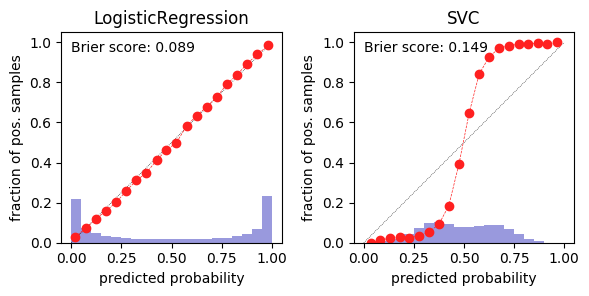

In [43]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve

def load_data():
    X, y = make_classification(n_samples=100000, n_features=20, random_state=0)
    train_samples = 2000  # Samples used for training the models
    X_train = X[:train_samples]
    X_test = X[train_samples:]
    y_train = y[:train_samples]
    y_test = y[train_samples:]

    return X_train, X_test, y_train, y_test

Xc_train, Xc_test, yc_train, yc_test = load_data()

def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of pos. samples")
    ax.set(aspect='equal')
    return curve

# Plot calibration curves for `models`, optionally show a calibrator run on a calibratee
def plot_calibration_comparison(models, calibrator=None, calibratee=None): 
    def get_probabilities(clf, X):
        if hasattr(clf, "predict_proba"): # Use probabilities if classifier has predict_proba
            prob_pos = clf.predict_proba(X)[:, 1]
        else:  # Otherwise, use decision function and scale
            prob_pos = clf.decision_function(X)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        return prob_pos
    
    nr_plots = len(models)
    if calibrator:
        nr_plots += 1
    fig, axes = plt.subplots(1, nr_plots, figsize=(3*nr_plots, 4*nr_plots))
    for ax, clf in zip(axes[:len(models)], models):
            clf.fit(Xc_train, yc_train)
            prob_pos = get_probabilities(clf,Xc_test)           
            bs = brier_score_loss(yc_test,prob_pos)
            plot_calibration_curve(yc_test, prob_pos, n_bins=20, ax=ax)
            ax.set_title(clf.__class__.__name__)
            ax.text(0,0.95,"Brier score: {:.3f}".format(bs))
    if calibrator:
        calibratee.fit(Xc_train, yc_train)
        # We're visualizing the trained calibrator, hence let it predict the training data
        prob_pos = get_probabilities(calibratee, Xc_train) # get uncalibrated predictions
        y_sort = [x for _,x in sorted(zip(prob_pos,yc_train))] # sort for nicer plots
        prob_pos.sort()
        cal_prob = calibrator.fit(prob_pos, y_sort).predict(prob_pos) # fit calibrator
        axes[-1].scatter(prob_pos,y_sort, s=2)
        axes[-1].scatter(prob_pos,cal_prob, s=2)
        axes[-1].plot(prob_pos,cal_prob)
        axes[-1].set_title("Calibrator: {}".format(calibrator.__class__.__name__))
        axes[-1].set_xlabel("predicted probability")
        axes[-1].set_ylabel("outcome")
        axes[-1].set(aspect='equal')
    plt.tight_layout()
    
plot_calibration_comparison([LogisticRegression(), SVC()])   

### Model calibration

* We can post-process trained models to make them more calibrated.
* Fit a regression model (a calibrator) to map the model's outcomes $f(x)$ to a calibrated probability in [0,1]
    * $f(x)$ returns the decision values or probability estimates
    * $f_{calib}$ must be fitted on held out data (not the training data for $f(x)$)
        * Often an internal cross-validation with few folds is used
    * Multi-class models require one calibrator per class

$$f_{calib}(f(x))≈p(y)$$

### Platt Scaling
* Calibrator is a logistic (sigmoid) function:
    * Learn the weight $w_1$ and bias $w_0$ from data
$$f_{platt}=\frac{1}{1+\exp(−w_1 f(x)− w_0)}$$

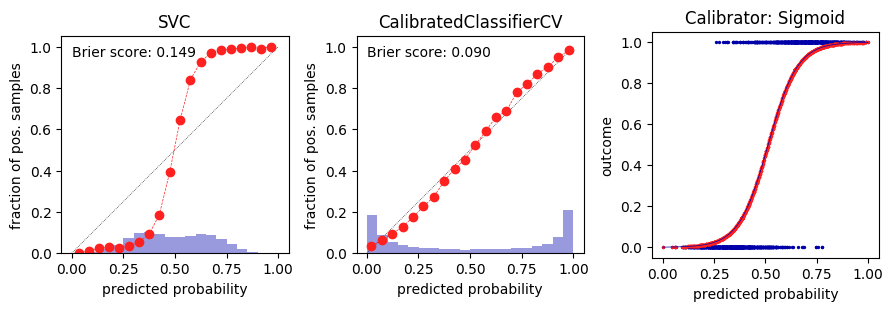

In [44]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Wrapped LogisticRegression to get sigmoid predictions
class Sigmoid():
    model = LogisticRegression()
    
    def fit(self, X, y):
        self.model.fit(X.reshape(-1, 1),y)
        return self

    def predict(self, X):
        return self.model.predict_proba(X.reshape(-1, 1))[:, 1]
        
svm = SVC()
svm_platt = CalibratedClassifierCV(svm, cv=2, method='sigmoid')
plot_calibration_comparison([svm, svm_platt],Sigmoid(),svm)

### Isotonic regression
* Maps input $x_i$ to an output $\hat{y}_i$ so that $\hat{y}_i$ increases monotonically with $x_i$ and minimizes loss $\sum_i^n (y_i-\hat{y}_i)$
    * Predictions are made by interpolating the predicted $\hat{y}_i$
* Fit to minimize the loss between the uncalibrated predictions $f(x)$ and the actual labels 
* Corrects any monotonic distortion, but tends to overfit on small samples

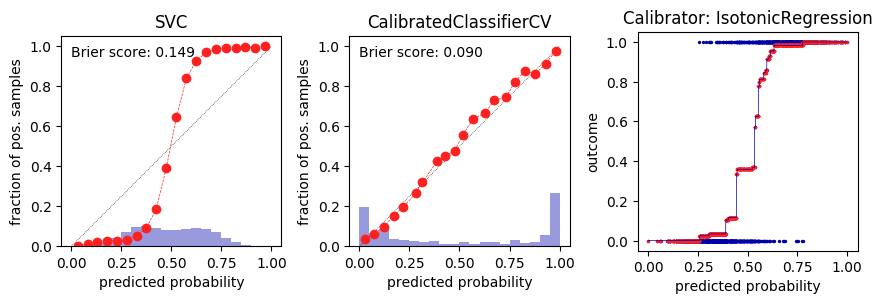

In [45]:
from sklearn.isotonic import IsotonicRegression

model = SVC()
iso = CalibratedClassifierCV(model, cv=2, method='isotonic')
plot_calibration_comparison([model, iso],IsotonicRegression(),model)

### Other useful classification metrics
- Cohen's Kappa
    - Measures 'agreement' between different models (aka inter-rater agreement)
    - To evaluate a single model, compare it against a model that does random guessing
        - Similar to accuracy, but taking into account the possibility of predicting the right class by chance
    - Can be weighted: different misclassifications given different weights
    - 1: perfect prediction, 0: random prediction, negative: worse than random
    - With $p_0$ = accuracy, and $p_e$ = accuracy of random classifier:
        $$\kappa = \frac{p_o - p_e}{1 - p_e}$$
- Matthews correlation coefficient
    - Corrects for imbalanced data, alternative for balanced accuracy or AUROC
    - 1: perfect prediction, 0: random prediction, -1: inverse prediction
        $$MCC = \frac{tp \times tn - fp \times fn}{\sqrt{(tp + fp)(tp + fn)(tn + fp)(tn + fn)}}$$

## Regression metrics

Most commonly used are
- mean squared error: $\frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{n}$
    - root mean squared error (RMSE) often used as well
- mean absolute error: $\frac{\sum_{i}|y_{pred_i}-y_{actual_i}|}{n}$
    - Less sensitive to outliers and large errors

<img src="../images/distracted_rmse.jpg" alt="ml" style="width: 500px;"/>

### R squared
- $R^2 = 1 - \frac{\color{blue}{\sum_{i}(y_{pred_i}-y_{actual_i})^2}}{\color{red}{\sum_{i}(y_{mean}-y_{actual_i})^2}}$
    - Ratio of variation explained by the model / total variation
    - Between 0 and 1, but _negative_ if the model is worse than just predicting the mean
    - Easier to interpret (higher is better).
    
<img src="../images/07_r2.png" alt="ml" style="width: 600px;"/>

#### Visualizing regression errors
* Prediction plot (left): predicted vs actual target values
* Residual plot (right): residuals vs actual target values
    * Over- and underpredictions can be given different costs 

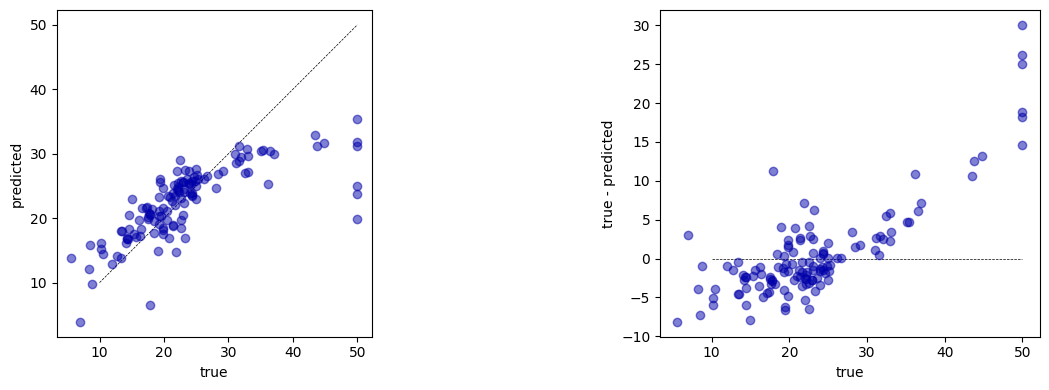

In [46]:
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston
boston = load_boston()

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)

pred = Ridge(normalize=True).fit(X_train, y_train).predict(X_test)

plt.subplot(1, 2, 1)
plt.gca().set_aspect("equal")
plt.plot([10, 50], [10, 50], '--', c='k')
plt.plot(y_test, pred, 'o', alpha=.5)
plt.ylabel("predicted")
plt.xlabel("true");

plt.subplot(1, 2, 2)
plt.gca().set_aspect("equal")
plt.plot([10, 50], [0,0], '--', c='k')
plt.plot(y_test, y_test - pred, 'o', alpha=.5)
plt.xlabel("true")
plt.ylabel("true - predicted")
plt.tight_layout();

## Bias-Variance decomposition

- Evaluate the same algorithm multiple times on different random samples of the data
- Two types of errors can be observed:
    - Bias error: systematic error, independent of the training sample
        - These points are predicted (equally) wrong every time
    - Variance error: error due to variability of the model with respect to the training sample
        - These points are sometimes predicted accurately, sometimes inaccurately

<img src="../images/03_bias_variance.png" alt="ml" style="width: 400px;"/>

#### Computing bias and variance error
- Take 100 or more bootstraps (or shuffle-splits)
- Regression: for each data point x:
    - $bias(x)^2 = (x_{true} - mean(x_{predicted}))^2$
    - $variance(x) = var(x_{predicted})$
- Classification: for each data point x:
    - $bias(x)$ = misclassification ratio
    - $variance(x) = (1 - (P(class_1)^2 + P(class_2)^2))/2$
        - $P(class_i)$ is ratio of class $i$ predictions
- Total bias: $\sum_{x} bias(x)^2 * w_x$
    $w_x$: the percentage of times $x$ occurs in the test sets
- Total variance: $\sum_{x} variance(x) * w_x$

In [47]:
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

### Bias and variance, underfitting and overfitting
- High variance means that you are likely overfitting
    - Use more regularization or use a simpler model
- High bias means that you are likely underfitting
    - Do less regularization or use a more flexible/complex model
- Ensembling techniques (see later) reduce bias or variance directly
    - Bagging (e.g. RandomForests) reduces variance, Boosting reduces bias

<img src="../images/03_Bias-Variance-Tradeoff.png" alt="ml" style="width: 500px;"/>

### Understanding under- and overfitting
- Regularization reduces variance error (increases stability of predictions)
    - But too much increases bias error (inability to learn 'harder' points)
- High regularization (left side): Underfitting, high bias error, low variance error
    - High training error and high test error
- Low regularization (right side): Overfitting, low bias error, high variance error
    - Low training error and higher test error

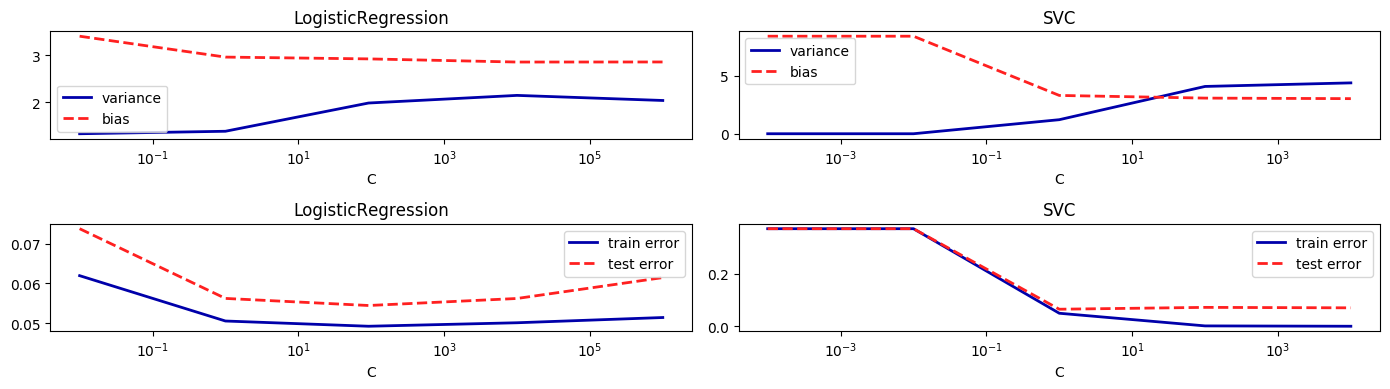

In [48]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
cancer = load_breast_cancer()

def plot_bias_variance(clf, param, X, y, ax):
    bias_scores = []
    var_scores = []
    err_scores = []
    name, vals = next(iter(param.items()))

    for i in vals:
        b,v,e = compute_bias_variance(clf.set_params(**{name:i}),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    ax.set_title(clf.__class__.__name__)
    ax.plot(vals, var_scores,label ="variance", lw=2 )
    ax.plot(vals, bias_scores,label ="bias", lw=2 )
    ax.set_xscale('log')
    ax.set_xlabel(name)
    ax.legend(loc="best")
    
def plot_train_test(clf, param, X, y, ax):
    gs = GridSearchCV(clf, param, cv=5, return_train_score=True).fit(X,y)
    name, vals = next(iter(param.items()))

    ax.set_title(clf.__class__.__name__)
    ax.plot(vals, (1-gs.cv_results_['mean_train_score']),label ="train error", lw=2 )
    ax.plot(vals, (1-gs.cv_results_['mean_test_score']),label ="test error", lw=2 )
    ax.set_xscale('log')
    ax.set_xlabel(name)
    ax.legend(loc="best")
    
fig, axes = plt.subplots(2, 2)
X, y = cancer.data, cancer.target
svm = SVC(gamma=2e-4, random_state=0)
param = {'C': [1e-4, 1e-2, 1, 1e2, 1e4]}

plot_bias_variance(svm, param, X, y, axes[0,1])
plot_train_test(svm, param, X, y, axes[1,1]) 

lr = LogisticRegression(random_state=0)
param = {'C': [1e-2, 1, 92, 1e4, 1e6]}
plot_bias_variance(lr, param, X, y, axes[0,0])
plot_train_test(lr, param, X, y, axes[1,0])
plt.tight_layout()

Summary Flowchart (by Andrew Ng)

<img src="../images/03_Bias-Variance-Flowchart.png" alt="ml" style="width: 700px;"/>

## Hyperparameter tuning
- There exists a huge range of techniques to tune hyperparameters. The simplest:
    - Grid search: Choose a range of values for every hyperparameter, try every combination
        - Doesn't scale to many hyperparameters (combinatorial explosion)
    - Random search: Choose random values for all hyperparameters, iterate $n$ times
        - Generally better, especially when some hyperparameters are less important
- Many more advanced techniques exist, see lecture on Automated Machine Learning

<img src="../images/gridvsrandom.jpg" alt="ml" style="width: 650px;"/>

### Tuning setup
* First split the data in training and test sets (outer split)
* Split up the training data again (inner cross-validation)
    * Generate hyperparameter configurations (e.g. random/grid search)
    * Evaluate all configurations on all inner splits, select the best one (on average)
* Retrain best configurations on full training set, evaluate on held-out test data

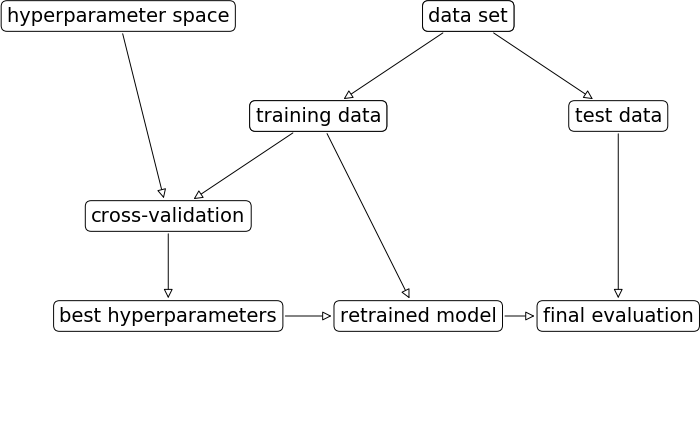

In [49]:
plt.rcParams['figure.dpi'] = 70 # Avoid overlapping boxes
mglearn.plots.plot_grid_search_overview()

#### Nested cross-validation
- Simplest approach: single outer split and single inner split (shown below)
- Risk of over-tuning hyperparameters on specific train-test split
    - Only recommended for very large datasets
- Nested cross-validation:
    - Outer loop: split full dataset in $k_1$ training and test splits
    - Inner loop: split training data into $k_2$ train and validation sets
- This yields $k_1$ scores for $k_1$ possibly different hyperparameter settings
    - Average score is the expected performance of the tuned model
- To use the model in practice, retune on the **entire** dataset

``` python
param_grid = {'C': expon(scale=100), 'gamma': expon(scale=.1)}
scores = cross_val_score(RandomizedSearchCV(SVC(), param_grid, cv=3), X, y, cv=5)
```

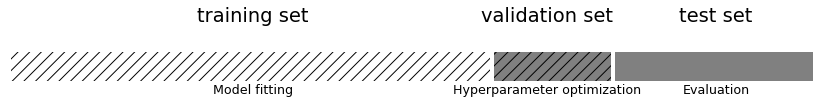

In [50]:
mglearn.plots.plot_threefold_split()

# Summary
* Split the data into training and test sets according to the application
    * Holdout only for large datasets, cross-validation for smaller ones
    * For classification, always use stratification
    * Grouped or ordered data requires special splitting
* Choose a metric that fits your application
    * E.g. precision to avoid false positives, recall to avoid true negatives
* Calibrate the decision threshold to fit your application
    * ROC curves or Precision-Recall curves can help to find a good tradeoff
* If possible, include the actual or relative costs of misclassifications
    * Class weighting, instance weighting, ROC isometrics can help
    * Be careful with imbalanced or unrepresentative datasets
* When using the predicted probabilities in applications, calibrate the models
* Always tune the most important hyperparameters
    * Manual tuning: Use insight and train-test scores for guidance
    * Hyperparameter optimization: be careful not to over-tune